In [7]:
import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images

In [8]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [9]:
# class CFG:
#     model_type = 'LightGBM'
#     num_popular_items = 12
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     dynamic_feature_weeks = 8
#     volume_feature_weeks = 1


# BEST
class CFG:
    model_type = 'CatBoost'
    num_popular_items = 12
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    dynamic_feature_weeks = 8
    volume_feature_weeks = 1

NO_COMPONENTS = 128

In [10]:
def train_lfm(
        transactions: pd.DataFrame,
        n_user: int,
        n_item: int,
        week_start: int,
        week_num: int,
):
    from lightfm import LightFM
    import psutil
    from scipy import sparse
    import pickle
    week_end = week_start + week_num
    a = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
    n_user = len(users)
    n_item = len(items)

    a_train = sparse.lil_matrix((n_user, n_item))
    a_train[a['user'], a['item']] = 1

    no_components = NO_COMPONENTS
    lightfm_params = {
        'no_components': no_components,
        'learning_schedule': 'adadelta',
        'loss': 'bpr',
        'learning_rate': 0.005,
    }

    model = LightFM(**lightfm_params)
    model.fit(a_train, epochs=100, num_threads=psutil.cpu_count(logical=False), verbose=True)
    with open(f"lfm_{week_start}.pkl", 'wb') as f:
        pickle.dump(model, f)

    # user_embs = pd.DataFrame({
    #     'user': users['user'],
    # })
    # a = np.hstack([model.user_embeddings, np.reshape(model.user_biases, (len(model.user_biases), 1))])
    # user_embeddings = pd.DataFrame(
    #     a,
    #     columns=[f"hoge_{i}" for i in range(no_components+1)],
    # )
    # user_embs = pd.concat([user_embs, user_embeddings], axis=1)
    # user_embs.to_csv(f'user{week_start}.csv', index=False)

    # item_embs = pd.DataFrame({
    #     'item': items['item'],
    # })
    # a = np.hstack([model.item_embeddings, np.reshape(model.item_biases, (len(model.item_biases), 1))])
    # item_embeddings = pd.DataFrame(
    #     a,
    #     columns=[f"fuga_{i}" for i in range(no_components+1)],
    # )
    # item_embs = pd.concat([item_embs, item_embeddings], axis=1)
    # item_embs.to_csv(f'item{week_start}.csv', index=False)

In [11]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def lfm(
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        strategy = 'lfm'


        from lightfm import LightFM
        import faiss
        import psutil
        from scipy import sparse

        NUM_ITEMS = 24
        week_end = week_start + week_num
        a = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        n_user = len(users)
        n_item = len(items)
    
        a_train = sparse.lil_matrix((n_user, n_item))
        a_train[a['user'], a['item']] = 1
    
        no_components = NO_COMPONENTS
        lightfm_params = {
            'no_components': no_components,
            'learning_schedule': 'adadelta',
            'loss': 'bpr',
            'learning_rate': 0.005,
        }
    
        model = LightFM(**lightfm_params)
        model.fit(a_train, epochs=100, num_threads=psutil.cpu_count(logical=False), verbose=True)

        user_embs = pd.DataFrame({
            'user': users['user'],
        })
        a = np.hstack([model.user_embeddings, np.reshape(model.user_biases, (len(model.user_biases), 1))])
        user_embeddings = pd.DataFrame(
            a,
            columns=[f"hoge_{i}" for i in range(no_components+1)],
        )
        user_embs = pd.concat([user_embs, user_embeddings], axis=1)
        user_embs.to_csv(f'user{week_start}.csv', index=False)

        item_embs = pd.DataFrame({
            'item': items['item'],
        })
        a = np.hstack([model.item_embeddings, np.reshape(model.item_biases, (len(model.item_biases), 1))])
        item_embeddings = pd.DataFrame(
            a,
            columns=[f"fuga_{i}" for i in range(no_components+1)],
        )
        item_embs = pd.concat([item_embs, item_embeddings], axis=1)
        item_embs.to_csv(f'item{week_start}.csv', index=False)

        # index = faiss.index_factory(no_components, "Flat", faiss.METRIC_INNER_PRODUCT)
        # index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        # index.add(model.item_embeddings)

        # _, candidates = index.search(model.user_embeddings[target_users], 1000)
        
        # result = model.predict(np.repeat(target_users, 1000), candidates.flatten(), num_threads=psutil.cpu_count(logical=False))
        # result = result.reshape(len(target_users), 1000)
        
        # idxs = np.argsort(result, axis=1)[:,::-1][:,:NUM_ITEMS]
        # idxs = np.array([candidates[i, x] for i, x in enumerate(idxs)])

        # return pd.DataFrame({
        #     'user': np.repeat(target_users, NUM_ITEMS),
        #     'item': idxs.flatten(),
        #     'lfm_rank': list(range(NUM_ITEMS)) * len(target_users),
        #     'strategy': 'lfm',
        # })

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_num: int) -> pd.DataFrame:
        week_end = week_start + week_num
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.num_popular_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.num_popular_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        # TODO: 元々バグってたので閾値とか要検討
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("cnt > 50").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week, 1)

    candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)
    # candidates_lfm = lfm(transactions, week, CFG.repurchase_weeks, candidates_item2item)
    train_lfm(transactions, len(users), len(items), week, CFG.repurchase_weeks)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    # candidates_lfm = drop_common_user_item(candidates_lfm, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        # candidates_lfm,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [12]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 1


Epoch: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


volume: 12354253
duplicates: 1.0596052180843134
            strategy   volume     ratio
0  same_product_code  6876142  0.556581
1         repurchase  3446562  0.278978
2               cooc  1203741  0.097435
3                pop   827808  0.067006
week: 2


Epoch: 100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


volume: 13148159
duplicates: 1.0663447719892427
            strategy   volume     ratio
0  same_product_code  7228749  0.549792
1         repurchase  3637145  0.276628
2               cooc  1418037  0.107851
3                pop   864228  0.065730
week: 3


Epoch: 100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


volume: 13922204
duplicates: 1.0692281686575584
            strategy   volume     ratio
0  same_product_code  7678831  0.551553
1         repurchase  3742824  0.268838
2               cooc  1590685  0.114255
3                pop   909864  0.065353
week: 4


Epoch: 100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


volume: 14853722
duplicates: 1.0730213586103197
            strategy   volume     ratio
0  same_product_code  8177755  0.550553
1         repurchase  3915353  0.263594
2               cooc  1797578  0.121019
3                pop   963036  0.064835


In [13]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [14]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


week: 0
Recall: 0.10367382841742775
            strategy       y   volume    recall  hit_ratio
0         repurchase  8437.0  3446562  0.039475   0.002448
1  same_product_code  7888.0  6876142  0.036907   0.001147
2               cooc  5096.0  1203741  0.023843   0.004233
3                pop  4833.0   827808  0.022613   0.005838
week: 1
Recall: 0.09945592558466061
            strategy       y   volume    recall  hit_ratio
0         repurchase  8955.0  3637145  0.039292   0.002462
1  same_product_code  8554.0  7228749  0.037532   0.001183
2               cooc  5210.0  1418037  0.022860   0.003674
3                pop  4539.0   864228  0.019916   0.005252
week: 2
Recall: 0.101040012769139
            strategy       y   volume    recall  hit_ratio
0         repurchase  9195.0  3742824  0.038622   0.002457
1  same_product_code  8829.0  7678831  0.037085   0.001150
2               cooc  5376.0  1590685  0.022581   0.003380
3                pop  5342.0   909864  0.022438   0.005871
week: 3
R

In [15]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 12354253 -> 3469506
drop trivial queries: 13148159 -> 3681372
drop trivial queries: 13922204 -> 3919804
drop trivial queries: 14853722 -> 3965310


In [16]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    week_end = week + CFG.volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
    # tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # week_end = week + CFG.volume_feature_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()

    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    week_end = week + CFG.volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    import pickle
    import psutil
    with open(f"lfm_{week}.pkl", 'rb') as f:
        model = pickle.load(f)

    df['lfm'] = model.predict(df['user'].values, df['item'].values, num_threads=psutil.cpu_count(logical=False))

    # df = df.merge(pd.read_csv(f"user{week}.csv"), on=['user'])
    # df = df.merge(pd.read_csv(f"item{week}.csv"), on=['item'])
    # hoges = [f"hoge_{i}" for i in range(NO_COMPONENTS)]
    # fugas = [f"fuga_{i}" for i in range(NO_COMPONENTS)]
    # a = np.sum(df[hoges].values * df[fugas].values, axis=1)
    # df['dot'] = a# + df[f'hoge_{NO_COMPONENTS}'] + df[f'fuga_{NO_COMPONENTS}']
    # df = df.drop(hoges, axis=1)
    # df = df.drop(fugas, axis=1)
    # df = df.drop([f'hoge_{NO_COMPONENTS}', f'fuga_{NO_COMPONENTS}'], axis=1)

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 1)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 1+idx)

week: 1
week: 1
week: 2
week: 3
week: 4


In [17]:
for idx in range(len(candidates)):
    candidates[idx]['query_group'] = candidates[idx]['week'].astype(str) + '_' + candidates[idx]['user'].astype(str)
    candidates[idx] = candidates[idx].sort_values(by='query_group').reset_index(drop=True)

In [18]:
def concat_train(candidates, begin, num):
    train = pd.concat([candidates[idx] for idx in range(begin, begin+num)])
    return train

valid = candidates[0]
train = concat_train(candidates, 1, CFG.train_weeks)

In [19]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_item_day_min', 'user_item_volume', 'lfm']


In [20]:
# feature_columns = [c for c in feature_columns if not c.startswith('hoge') and not c.startswith('fuga')]
# feature_columns

In [21]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [22]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1765897	best: 0.1765897 (0)	total: 1.66s	remaining: 27m 37s
1:	test: 0.2007845	best: 0.2007845 (1)	total: 3.2s	remaining: 26m 35s
2:	test: 0.2286868	best: 0.2286868 (2)	total: 4.67s	remaining: 25m 53s
3:	test: 0.2645379	best: 0.2645379 (3)	total: 6.16s	remaining: 25m 33s
4:	test: 0.2709110	best: 0.2709110 (4)	total: 7.64s	remaining: 25m 21s
5:	test: 0.2756614	best: 0.2756614 (5)	total: 9.1s	remaining: 25m 6s
6:	test: 0.2766818	best: 0.2766818 (6)	total: 10.6s	remaining: 25m 3s
7:	test: 0.2797387	best: 0.2797387 (7)	total: 12.1s	remaining: 24m 59s
8:	test: 0.2794168	best: 0.2797387 (7)	total: 13.5s	remaining: 24m 49s
9:	test: 0.2985494	best: 0.2985494 (9)	total: 15s	remaining: 24m 40s
10:	test: 0.3182340	best: 0.3182340 (10)	total: 16.4s	remaining: 24m 37s
11:	test: 0.3181567	best: 0.3182340 (10)	total: 17.9s	remaining: 24m 34s
12:	test: 0.3197739	best: 0.3197739 (12)	total: 19.5s	remaining: 24m 40s
13:	test: 0.3243327	best: 0.3243327 (13)	total: 21s	remaining: 24m 40s
14:	te

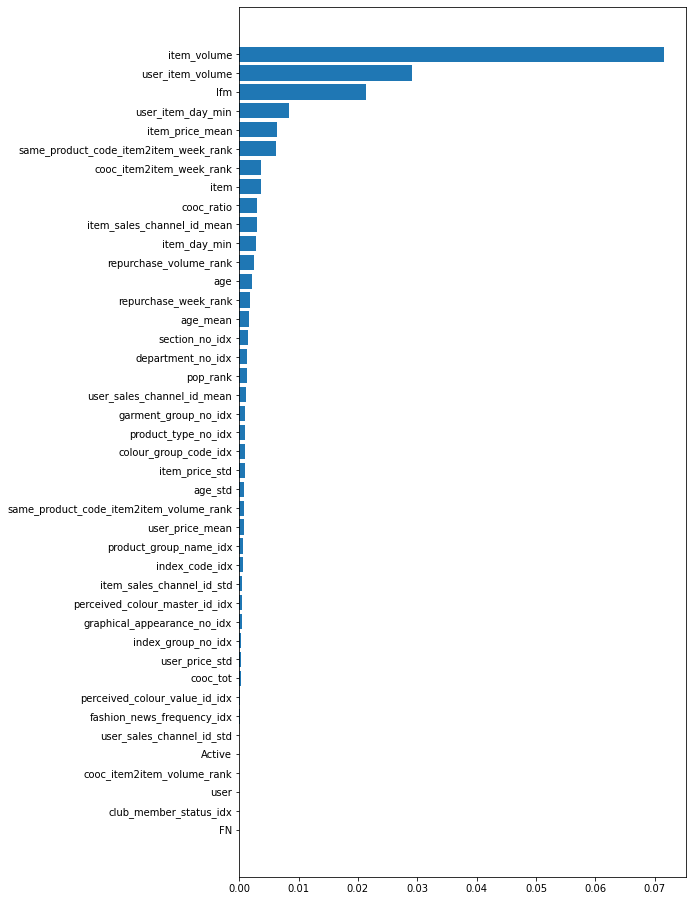

In [23]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
    }
    model = catboost.CatBoost(params)
    model.fit(train_pool, eval_set=valid_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [24]:
valid_all['pred'] = model.predict(valid_all[feature_columns])

In [25]:
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

In [26]:
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.032910224090889055


In [27]:
# assert False

AssertionError: 

submission

In [28]:
train = concat_train(candidates, 0, CFG.train_weeks)

0:	total: 1.4s	remaining: 22m 21s
1:	total: 2.78s	remaining: 22m 12s
2:	total: 4.16s	remaining: 22m 9s
3:	total: 5.57s	remaining: 22m 12s
4:	total: 6.95s	remaining: 22m 9s
5:	total: 8.3s	remaining: 22m 2s
6:	total: 9.7s	remaining: 22m 3s
7:	total: 11.1s	remaining: 22m
8:	total: 12.5s	remaining: 22m 2s
9:	total: 13.9s	remaining: 21m 58s
10:	total: 15.2s	remaining: 21m 56s
11:	total: 16.6s	remaining: 21m 56s
12:	total: 18s	remaining: 21m 56s
13:	total: 19.4s	remaining: 21m 56s
14:	total: 20.8s	remaining: 21m 54s
15:	total: 22.2s	remaining: 21m 53s
16:	total: 23.6s	remaining: 21m 52s
17:	total: 25s	remaining: 21m 52s
18:	total: 26.4s	remaining: 21m 49s
19:	total: 27.8s	remaining: 21m 48s
20:	total: 29.2s	remaining: 21m 46s
21:	total: 30.6s	remaining: 21m 48s
22:	total: 32s	remaining: 21m 46s
23:	total: 33.5s	remaining: 21m 48s
24:	total: 34.8s	remaining: 21m 45s
25:	total: 36.2s	remaining: 21m 43s
26:	total: 37.6s	remaining: 21m 43s
27:	total: 39s	remaining: 21m 41s
28:	total: 40.5s	remai

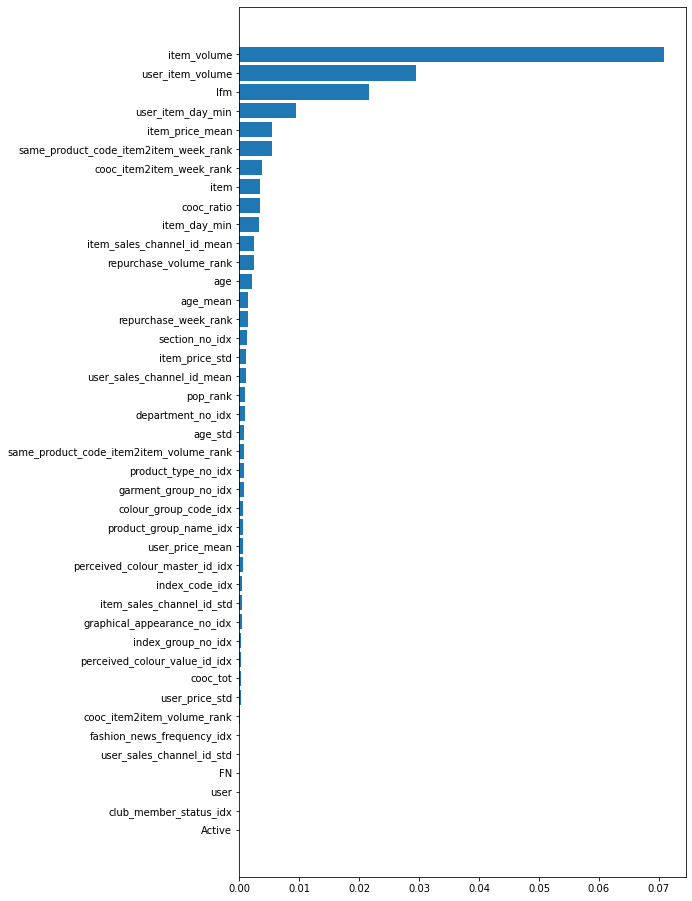

In [29]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [30]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [31]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

week: 0


Epoch: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


volume: 14676837
duplicates: 1.0446657395514116
            strategy   volume     ratio
0  same_product_code  9190204  0.626171
1         repurchase  2735882  0.186408
2                pop  1646376  0.112175
3               cooc  1104375  0.075246
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


volume: 14710948
duplicates: 1.0444707111229885
            strategy   volume     ratio
0  same_product_code  9210520  0.626100
1         repurchase  2752227  0.187087
2                pop  1646376  0.111915
3               cooc  1101825  0.074898
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


volume: 14616280
duplicates: 1.0445163691002588
            strategy   volume     ratio
0  same_product_code  9167920  0.627240
1         repurchase  2708651  0.185317
2                pop  1646376  0.112640
3               cooc  1093333  0.074802
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


volume: 14692662
duplicates: 1.0445994430997299
            strategy   volume     ratio
0  same_product_code  9204223  0.626450
1         repurchase  2737078  0.186289
2                pop  1646376  0.112054
3               cooc  1104985  0.075207
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


volume: 14681390
duplicates: 1.0446768401062139
            strategy   volume     ratio
0  same_product_code  9190841  0.626020
1         repurchase  2739307  0.186584
2                pop  1646376  0.112140
3               cooc  1104866  0.075256
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


volume: 14746901
duplicates: 1.0447815196766972
            strategy   volume     ratio
0  same_product_code  9243785  0.626829
1         repurchase  2745003  0.186141
2                pop  1646376  0.111642
3               cooc  1111737  0.075388
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


volume: 14636858
duplicates: 1.0450976469259323
            strategy   volume     ratio
0  same_product_code  9166138  0.626237
1         repurchase  2714357  0.185447
2                pop  1646376  0.112482
3               cooc  1109987  0.075835
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


volume: 14656260
duplicates: 1.0447553087612043
            strategy   volume     ratio
0  same_product_code  9175200  0.626026
1         repurchase  2731902  0.186398
2                pop  1646376  0.112333
3               cooc  1102782  0.075243
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


volume: 14585821
duplicates: 1.0444015743977701
            strategy   volume     ratio
0  same_product_code  9136160  0.626373
1         repurchase  2711285  0.185885
2                pop  1646376  0.112875
3               cooc  1092000  0.074867
week: 0
week: 0


Epoch: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


volume: 14669323
duplicates: 1.0447569759620023
            strategy   volume     ratio
0  same_product_code  9189583  0.626449
1         repurchase  2730747  0.186154
2                pop  1646376  0.112233
3               cooc  1102617  0.075165
week: 0


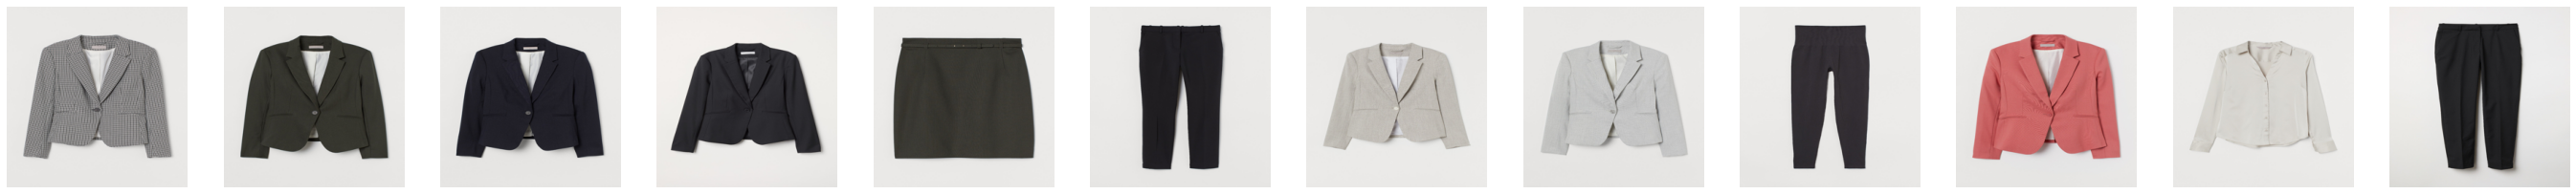

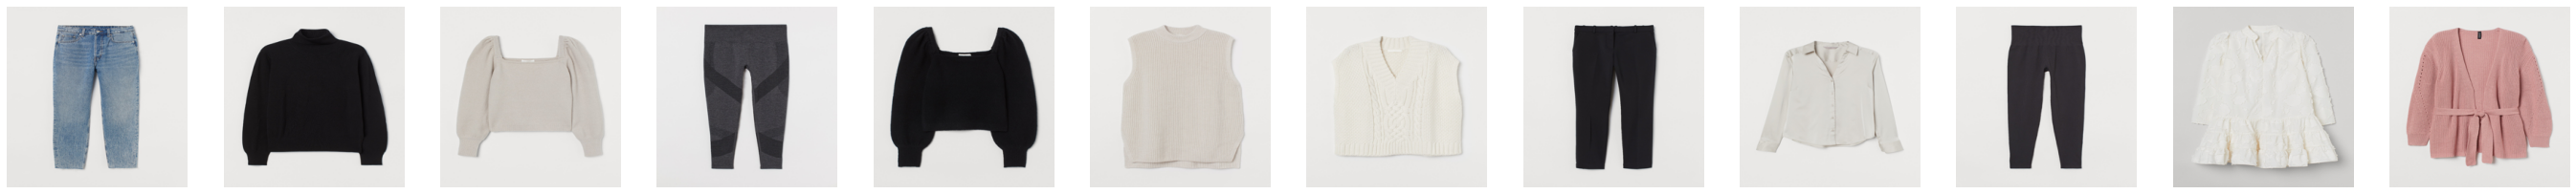

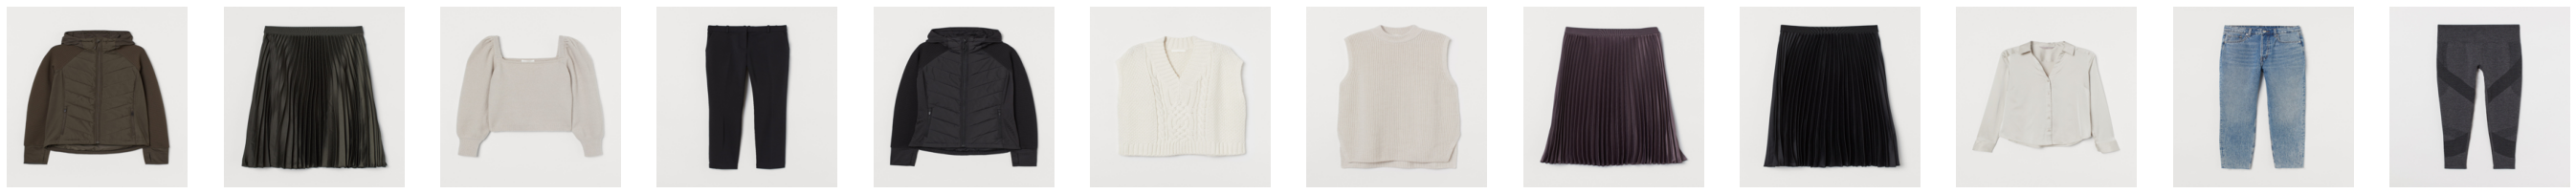

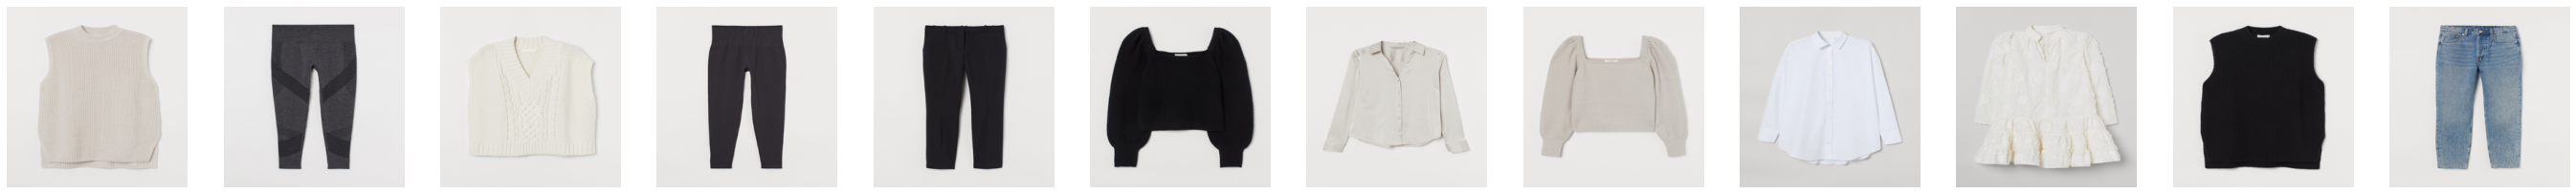

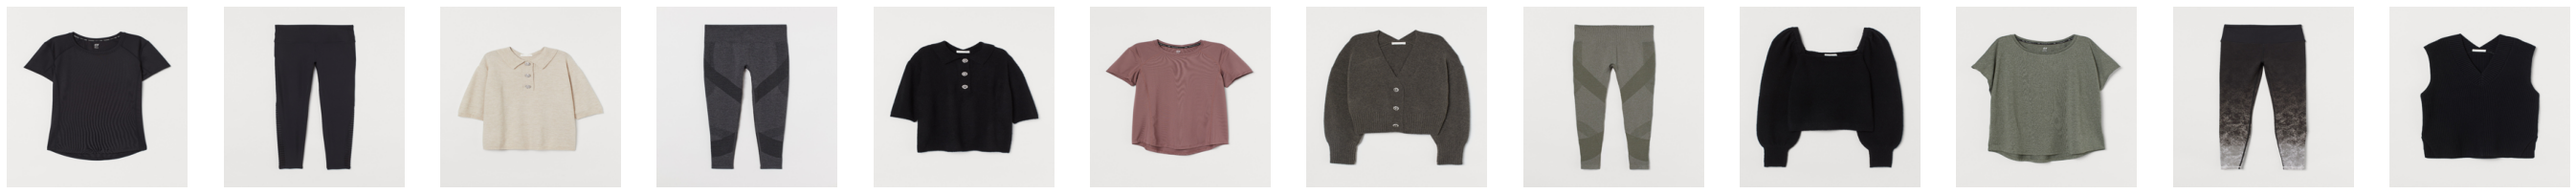

In [32]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [33]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601044 0568601043 0568601007 0568601006 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0673677002 0915529005 0918292001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0851400020 0915529005 0751471001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243001 0918292001 0918522001 0866731001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0791587001 0730683050 0896152001 0918292001 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587001 0557599022 0804992014 0804992017 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846026 0762846027 0762846006 0762846031 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846026 0762846029 0762846006 09...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0918522001 0448509014 0821395005 07...


In [34]:
submission.to_csv('submission.csv', index=False)